# Data Exploration for Product 2

In [1]:
!pip install s3fs
!pip install xlrd

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [46]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [47]:
s3_client = boto3.client('s3')

df = pd.read_csv('s3://invoice-ml/input/Dataset_Producto_2.csv', sep=',', encoding='latin-1')
df.head()

,Fecha,RFCCliente,Cliente,RFCPagador,Pagador,Factura,Folio,Moneda,FechaVencimiento,Monto,Comisión,Total,Ajuste,FechaPago,Status
0,19/10/2016,GGD140620GH7,GRUPO GARCHA INSUMOS INDUSTRIALES SA DE CV,GAI020902FG4,GRUPO AMERICAN INDUSTRIES S.A. DE C.V.,896,EFB2016026,MXN,01/12/2016,"26,022.28","1,116.46","24,905.82",-496.21,30/11/2016,Liquidado
1,19/10/2016,GGD140620GH7,GRUPO GARCHA INSUMOS INDUSTRIALES SA DE CV,GAI020902FG4,GRUPO AMERICAN INDUSTRIES S.A. DE C.V.,909,EFB2016026,MXN,01/12/2016,"35,047.66","1,503.69","33,543.97",-534.64,18/11/2016,Liquidado
2,19/10/2016,GGD140620GH7,GRUPO GARCHA INSUMOS INDUSTRIALES SA DE CV,GAI020902FG4,GRUPO AMERICAN INDUSTRIES S.A. DE C.V.,889,EFB2016026,MXN,01/12/2016,"34,078.48","1,462.11","32,616.37",-649.83,30/11/2016,Liquidado
3,20/10/2016,IAHR920121JY2,ROBERTO IBARRA HERRERA,GAI020902FG4,GRUPO AMERICAN INDUSTRIES S.A. DE C.V.,AAA1A517-1BA1-4BF-48F8-8E3B-63119FC912B3,EFB2016027,MXN,16/11/2016,"9,094.00",390.17,"8,703.83",-260.11,31/10/2016,Liquidado
4,25/10/2016,GGD140620GH7,GRUPO GARCHA INSUMOS INDUSTRIALES SA DE CV,GAI020902FG4,GRUPO AMERICAN INDUSTRIES S.A. DE C.V.,937,EFB2016028,MXN,01/12/2016,"26,938.92","1,155.79","25,783.13",-359.58,28/11/2016,Liquidado


# 1- Data cleaning

In [24]:
# Remove leading and trailing spaces
cols =['Fecha', 'RFCCliente', 'Cliente', 'RFCPagador', 'Pagador', 'Factura', 'Folio', 'Moneda', 'Status']

for col in cols:
    df[col] = df[col].str.strip()
    
# Removing new line character from dataframe
df.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)

# # Remove comma separator from numeric values
df["Monto"].replace({r",": ""}, regex=True, inplace=True)
df["Comisión"].replace({r",": ""}, regex=True, inplace=True)
df["Total"].replace({r",": ""}, regex=True, inplace=True)
df["Ajuste"].replace({r",": ""}, regex=True, inplace=True)

df.head()

,Fecha,RFCCliente,Cliente,RFCPagador,Pagador,Factura,Folio,Moneda,FechaVencimiento,Monto,Comisión,Total,Ajuste,FechaPago,Status
0,19/10/2016,GGD140620GH7,GRUPO GARCHA INSUMOS INDUSTRIALES SA DE CV,GAI020902FG4,GRUPO AMERICAN INDUSTRIES S.A. DE C.V.,896,EFB2016026,MXN,01/12/2016,26022.28,1116.46,24905.82,-496.21,30/11/2016,Liquidado
1,19/10/2016,GGD140620GH7,GRUPO GARCHA INSUMOS INDUSTRIALES SA DE CV,GAI020902FG4,GRUPO AMERICAN INDUSTRIES S.A. DE C.V.,909,EFB2016026,MXN,01/12/2016,35047.66,1503.69,33543.97,-534.64,18/11/2016,Liquidado
2,19/10/2016,GGD140620GH7,GRUPO GARCHA INSUMOS INDUSTRIALES SA DE CV,GAI020902FG4,GRUPO AMERICAN INDUSTRIES S.A. DE C.V.,889,EFB2016026,MXN,01/12/2016,34078.48,1462.11,32616.37,-649.83,30/11/2016,Liquidado
3,20/10/2016,IAHR920121JY2,ROBERTO IBARRA HERRERA,GAI020902FG4,GRUPO AMERICAN INDUSTRIES S.A. DE C.V.,AAA1A517-1BA1-4BF-48F8-8E3B-63119FC912B3,EFB2016027,MXN,16/11/2016,9094.00,390.17,8703.83,-260.11,31/10/2016,Liquidado
4,25/10/2016,GGD140620GH7,GRUPO GARCHA INSUMOS INDUSTRIALES SA DE CV,GAI020902FG4,GRUPO AMERICAN INDUSTRIES S.A. DE C.V.,937,EFB2016028,MXN,01/12/2016,26938.92,1155.79,25783.13,-359.58,28/11/2016,Liquidado


## 1.1 Change column format

In [25]:
df['Monto'] = pd.to_numeric(df['Monto'])
df['Comisión'] = pd.to_numeric(df['Comisión'])
df['Total'] = pd.to_numeric(df['Total'])


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2687 entries, 0 to 2686
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fecha             2687 non-null   object 
 1   RFCCliente        2687 non-null   object 
 2   Cliente           2687 non-null   object 
 3   RFCPagador        2687 non-null   object 
 4   Pagador           2687 non-null   object 
 5   Factura           2685 non-null   object 
 6   Folio             2687 non-null   object 
 7   Moneda            2687 non-null   object 
 8   FechaVencimiento  2687 non-null   object 
 9   Monto             2687 non-null   float64
 10  Comisión          2687 non-null   float64
 11  Total             2687 non-null   float64
 12  Ajuste            2687 non-null   float64
 13  FechaPago         2687 non-null   object 
 14  Status            2687 non-null   object 
dtypes: float64(4), object(11)
memory usage: 315.0+ KB


In [27]:
df.describe()

,Monto,Comisión,Total,Ajuste
count,2687.000000,2687.000000,2687.000000,2687.000000
mean,16709.937707,602.033115,16107.904693,21.175355
std,26663.450169,981.743028,25691.145624,179.207800
min,75.860000,0.000000,-88.640000,-2765.530000
25%,3280.480000,120.480000,3172.900000,0.000000
50%,6666.520000,220.100000,6447.890000,7.060000
75%,20421.800000,733.980000,19681.740000,39.460000
max,727425.790000,27901.260000,699524.530000,4464.200000


In [178]:
# Remove empty column 
df.drop('DiasFaltantes', inplace=True, axis=1)

# 1- Data Exploration

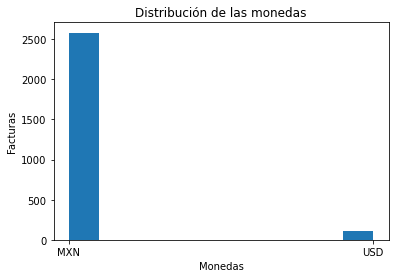

In [28]:
fig=plt.figure()
ax = fig.add_subplot()
ax.hist(df['Moneda'])
plt.title('Distribución de las monedas')
plt.xlabel('Monedas')
plt.ylabel('Facturas')
plt.show()

<AxesSubplot:xlabel='Monto', ylabel='Comisión'>

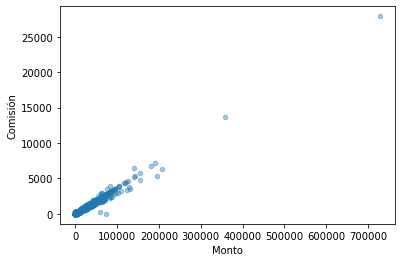

In [29]:
df.plot.scatter(x="Monto", y="Comisión", alpha=0.4)

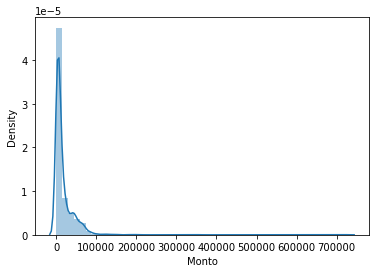

In [30]:
#histogram
sns.distplot(df['Monto']);

### Relationship with categorical features

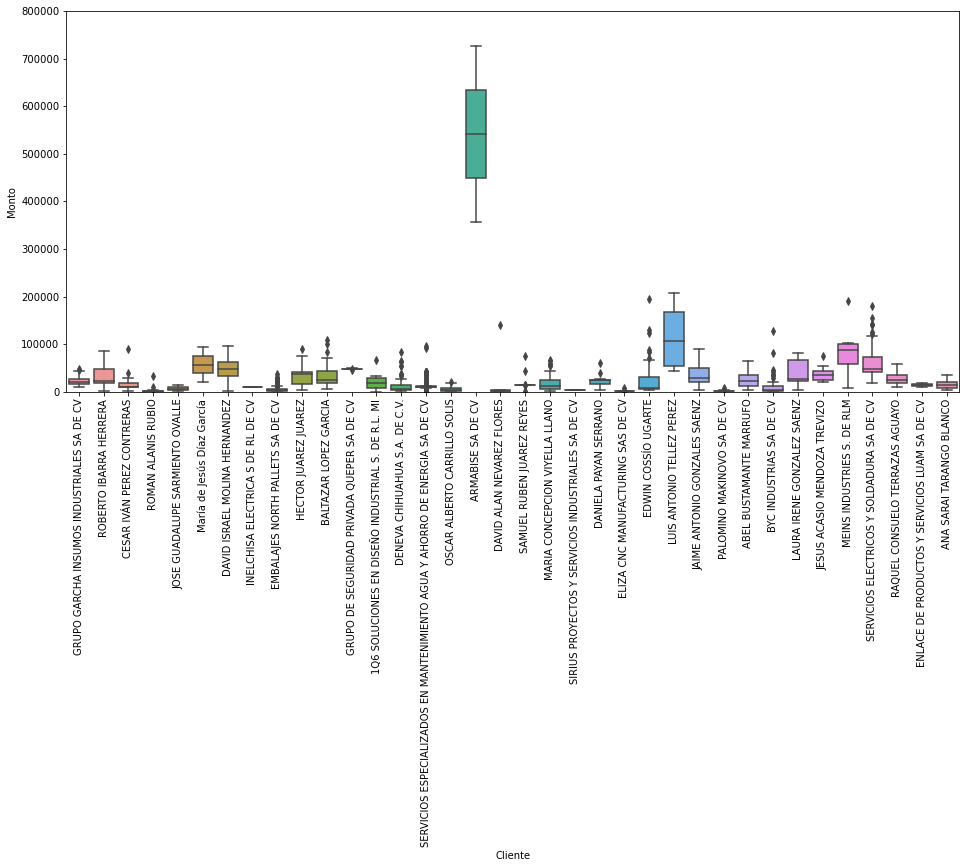

In [36]:
var = 'Cliente'
data = pd.concat([df['Monto'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 7))
fig = sns.boxplot(x=var, y="Monto", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);


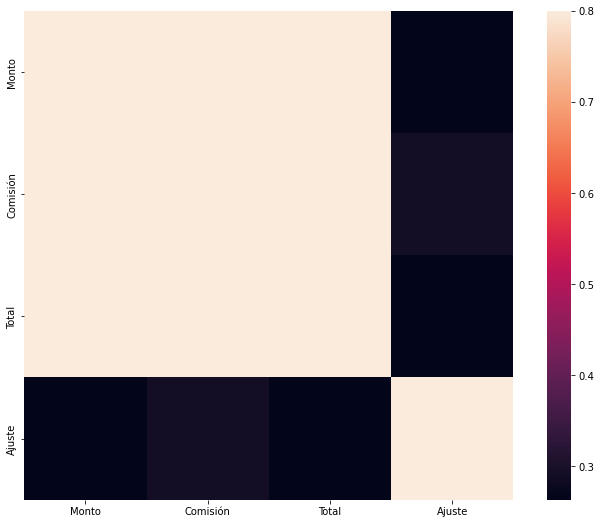

In [39]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

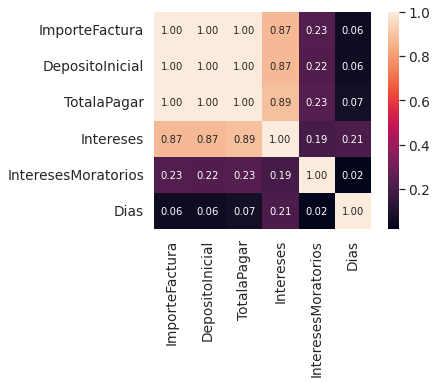

In [172]:
#ImporteFactura correlation matrix
k = 6 #number of variables for heatmap
cols = corrmat.nlargest(k, 'ImporteFactura')['ImporteFactura'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [21]:
# missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Factura,2,0.000744
Fecha,0,0.000000
RFCCliente,0,0.000000
Cliente,0,0.000000
RFCPagador,0,0.000000
Pagador,0,0.000000
Folio,0,0.000000
Moneda,0,0.000000
FechaVencimiento,0,0.000000
Monto,0,0.000000


In [180]:
df = pd.get_dummies(df)

In [181]:
df.head()

,Dias,Fecha_01/02/2017,Fecha_01/02/2018,Fecha_01/02/2019,Fecha_01/02/2022,Fecha_01/03/2018,Fecha_01/03/2019,Fecha_01/03/2021,Fecha_01/03/2022,Fecha_01/04/2020,...,FechaPago_2022-06-17\n\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t17/06/2022,FechaPago_2022-06-18\n\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t18/06/2022,FechaPago_2022-06-20\n\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t20/06/2022,FechaPago_2022-06-21\n\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t21/06/2022,FechaPago_2022-06-22\n\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t22/06/2022,FechaPago_2022-06-23\n\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t23/06/2022,FechaPago_2022-06-23\n\n23/06/2022,FechaPago_2022-06-23\n \n 23/06/2022,FechaPago_2022-06-24\n\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t24/06/2022,Status_Liquidado
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,74,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
